## **Peter Bevan 200731331**
## **CycleGAN Human-Anime-Human**

*This code was devloped mainly on Google Colab, and will be quicker to work with using `!gdown` to download preprocessed data hosted on google drive, however the notebook can still be run to process the data on other environments.*

This project aimed to transfer between human and anime faces using an implementation of the CycleGAN model in Keras with Tensorflow backend. The model is mostly taken from [machinelearningmastery.com](https://machinelearningmastery.com) with some tweeks, namely switching out the discriminator for one taken (with permission) from code by https://github.com/nanoxas, as well as a manually decayed learning rate. Many runs of 50,000+ passes led to either mode collapse or very poor results. Adjusting the anime images to be at a similar scale to the human faces (human training images were more zoomed in) seemed to allow the model to map facial features better and build from there. Further to this the results much improved with a discriminator with less stride convolutions and a dense layer. This could be due to the original model being prepared for 256x256 images whereas training the images in this project were fed into the model as 64x64. Once the results plateud at around 100,000 passes, the learning rate was decayed manually, as described by Jun-Yan Zhu et al. (2017) in the original paper, from 0.0002 to 0.0001. This seemed to add a little detail and clarity to the output. Further projects using cycleGAN I would maybe try and continue the decay linearly to 0 as the paper specifies, in an automated manner rather than manually.

Many lessons on checkpointing were painfully earned from this project, which will be carried forward into future projects.

# Prerequisites

In [ ]:
#installing keras-contrib for instance normalisation
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-4qmiyc4q
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-4qmiyc4q
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101065 sha256=489b4212323a4d0cf3c649d05fb90137831ebc215a6be9c683034ae15a3a2d9c
  Stored in directory: /tmp/pip-ephem-wheel-cache-spbep7oo/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [ ]:
#importing neccessary libraries

import zipfile
import os
import numpy as np
import shutil
from matplotlib import pyplot as plt
from random import sample
from random import random
from numpy.random import randint
from keras.models import load_model
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Sequential
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Flatten
from keras.layers import Dense
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

In [ ]:
#Setting random seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)

# Image Processing


**Two sets of images are downloaded from Stephen McGough. 'PubFig' is a set of images of celebrity faces**

In [ ]:
#download anime and public figures images from Stephen McGough using curl
!curl -O http://homepages.cs.ncl.ac.uk/stephen.mcgough/Teaching/anime.zip
print('anime dataset downloaded to working directory')
!curl -O http://homepages.cs.ncl.ac.uk/stephen.mcgough/Teaching/PubFig.zip
print('public figure faces dataset downloaded to working directory')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  175M  100  175M    0     0   314k      0  0:09:31  0:09:31 --:--:--  336k
public figure faces dataset downloaded to working directory


**The downloaded image files are unzipped into the working directory**

In [ ]:
#extracting zipped image files into directory

## Unzipping anime.zip
with zipfile.ZipFile('anime.zip', 'r') as zip_ref:
    zip_ref.extractall()
print('Anime faces dataset extracted to working directory as "images/"')

## Unzipping PubFig.zip
with zipfile.ZipFile('PubFig.zip', 'r') as zip_ref:
    zip_ref.extractall()
print('Public figure faces dataset extracted to working directory as "CelebDataProcessed/"\n')

Public figure faces dataset extracted to working directory as "CelebDataProcessed/"



**The celeb data is rearranged to pull the images out of their labelled folders and place all images in the main directory (labels not used in CycleGAN). The empty folders are then deleted.**

In [ ]:
#renaming files in celeb data to be random unique names (so they can all reside in the same directory)
for root, dirs, files in os.walk('CelebDataProcessed/'):
    for name in files:
        newname = str(np.random.choice(range(1,17000))) + name
        os.rename(os.path.join(root,name), os.path.join(root,newname))

## moving all images out of labelled subdirectory and into the main folder
folder = r"CelebDataProcessed/" #defining folder to search
subfolders = [f.path for f in os.scandir(folder) if f.is_dir()] #defining subfolders
#looping through folders to move images
for sub in subfolders:
    for f in os.listdir(sub):
        src = os.path.join(sub, f)
        dst = os.path.join(folder, f)
        shutil.move(src, dst)

#deleting empty folders
path_abs=('CelebDataProcessed/') #defining path for empty folders
walk = list(os.walk(path_abs))
for path, _, _ in walk[::-1]:
    if len(os.listdir(path)) == 0:
        os.rmdir(path)

**The number of images loaded for each of the source and target are shown below.**

In [ ]:
#Printing image counts
celeb_image_count = len(os.listdir('CelebDataProcessed/'))
anime_image_count = len(os.listdir('images/'))
print(f'There are {celeb_image_count} images of celebrity faces (source)')
print(f'There are {anime_image_count} images of anime faces (target)')

There are 11000 images of celebrity faces (source)
There are 52000 images of anime faces (target)


**The full set of images proved too much for the RAM limits on google colab, and so were trimmed down using the code block below. This may not be the case for whoever is running this code so feel free to uncomment this block and use it as needed.**

In [ ]:
# # Trimming down files to stop notebook running out of RAM whilst processing
# def delete_files(filepath, number):
#   for i, image in enumerate(os.listdir(filepath)):
#     if i <= number:
#       img_path = os.path.join(filepath,image)
#       os.remove(img_path)

# delete_files('/content/CelebDataProcessed', 596)
# delete_files('/content/images', 7999)

# #Reprinting image counts
# celeb_image_count = len(os.listdir('CelebDataProcessed/'))
# anime_image_count = len(os.listdir('images/'))
# print(f'There are {celeb_image_count} images of celebrity faces (source)')
# print(f'There are {anime_image_count} images of anime faces (target)')

**The images are then processed as numpy arrays. The anime images are forced into 100x100 arrays and then sliced down into 64x64 arrays in a way that frames the face in a similar fashion to the celeb faces. Some resolution is sacraficed here but it proved worth it as this seemed to produce much better results than training on the original images.**

In [ ]:
## Defining function to process images as numpy arrays and store locally as zipfile to save RAM

#defineing image size
image_size_source = (64,64)
image_size_target = (100,100)

def numpy_arrayify(desired_filename,filepath_source, filepath_target):
  #processing source images
  source_list = list()
  for filename in os.listdir(filepath_source):
    pic = load_img(filepath_source + filename, target_size=image_size_source)
    pic = img_to_array(pic)
    pic = pic.astype('float32')
    source_list.append(pic)
  source_list = np.asarray(source_list)
# processing target images
  target_list = list()
  for filename in os.listdir(filepath_target):
    pic2 = load_img(filepath_target + filename, target_size=image_size_target)
    pic2 = img_to_array(pic2)
    pic2 = pic2.astype('float32')
    target_list.append(pic2)
  target_list = np.asarray(target_list)
#crop anime faces to 64x64 and similar face size to celeb
  target_list = target_list[:, 26:90, 18:82, :]
# saving as zipped numpy file
  np.savez_compressed(desired_filename, source_list, target_list)

In [ ]:
# Using function on celeb and anime faces to save as single zip ready for training
numpy_arrayify('celeb_anime.npz','CelebDataProcessed/','images/')
print('------------------------------------------------------')
print('numpy arrays of images saved to environment as celeb_anime.npz')
print('------------------------------------------------------')

------------------------------------------------------
numpy arrays of images saved to environment as celeb_anime.npz
------------------------------------------------------


# **!!!** If you do not wish to wait for the above code to process the data, please download the preprocessed zipped numpy arrays containing the celebrity faces and anime faces

In [ ]:
## download this if you want the preprocessed images ready for training
#!pip install gdown # Execute this if you don't have gdown
!gdown --id 1EdtNjgUeMUiUZVTm2MyUnUKIDnqm4Gee

Downloading...
From: https://drive.google.com/uc?id=1EdtNjgUeMUiUZVTm2MyUnUKIDnqm4Gee
To: /content/celeb_anime.npz
741MB [00:09, 75.1MB/s]


**Loading arrays from the zip folder to visualise**

In [ ]:
#loading zipped file
data = np.load('celeb_anime.npz')
#assigning numpy arrays
celeb, anime = data['arr_0'], data['arr_1']

print('---------------------------------------')
print(f'Celeb data is shape: {celeb.shape}')
print('---------------------------------------')
print(f'Anime data is shape: {anime.shape}')
print('---------------------------------------')

---------------------------------------
Celeb data is shape: (11000, 64, 64, 3)
---------------------------------------
Anime data is shape: (44000, 64, 64, 3)
---------------------------------------


**Visualising a sample of the source and target images**

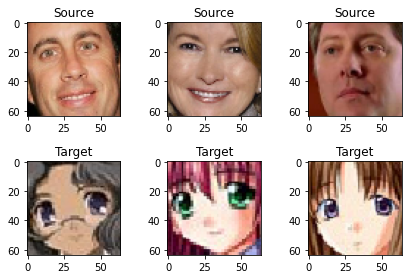

In [ ]:
### plotting sample of three of the source (celeb pics) and target (anime pics)
### side by side
fig, axs = plt.subplots(2, 3)
fig.tight_layout(pad=1.0)
for i in range(3):
  axs[0, i].imshow(celeb[i].astype('uint8'))
  axs[0, i].set_title('Source')
  axs[1, i].imshow(anime[i].astype('uint8'))
  axs[1, i].set_title('Target')


**The model was configured to save the weights every 5000 passes and output image samples every 1000. This allowed the best model to be selected from the saved weights by looking over the image samples. These were originally being saved to the working directory and were frustratingly lost when the runtime collapsed. Following this google drive was implemented to save the files, however this also resulted in disaster on one occasion after the 15GB limit was exceeded. Lessons were eventually learned and this was overcome.**

# **Main model**

In [ ]:
# define the discriminator model

# def define_discriminator(image_shape, filepath='NULL'):
# 	# weight initialization
# 	init = RandomNormal(stddev=0.02)
# 	# source image input
# 	in_image = Input(shape=image_shape)
# 	# C64
# 	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
# 	d = LeakyReLU(alpha=0.2)(d)
# 	# C128
# 	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
# 	d = InstanceNormalization(axis=-1)(d)
# 	d = LeakyReLU(alpha=0.2)(d)
# 	# C256
# 	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
# 	d = InstanceNormalization(axis=-1)(d)
# 	d = LeakyReLU(alpha=0.2)(d)
# 	# C512
# 	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
# 	d = InstanceNormalization(axis=-1)(d)
# 	d = LeakyReLU(alpha=0.2)(d)
# 	# second last output layer
# 	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
# 	d = InstanceNormalization(axis=-1)(d)
# 	d = LeakyReLU(alpha=0.2)(d)
# 	# patch output
# 	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
# 	# define model
# 	model = Model(in_image, patch_out)
#   # compile model
# 	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
# 	if filepath != 'NULL':
# 		model.load_weights(filepath)
# 	return model

def build_discriminator_sn(shape):
    model = Sequential()

    model.add(
        Conv2D(
            64, (3, 3), strides=(
                2, 2), padding="same", input_shape=shape))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding="same"))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(256, (3, 3), strides=(2, 2), padding="same"))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(512, (3, 3), strides=(2, 2), padding="same"))
    model.add(LeakyReLU(0.2))

    #model.add(Conv2D(1, (3, 3), padding="same"))
    model.add(Flatten())
    # model.add(GlobalAveragePooling2D())
    model.add(Dense(1))
    # model.add(Activation('sigmoid'))

    # compile model
    model.compile(loss='mse', optimizer=Adam(lr=0.0001, beta_1=0.5), loss_weights=[0.5])

    return model
 
# generator a resnet block
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g
 
# define the standalone generator model
def define_generator(image_shape, n_resnet=9, filepath='NULL'):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	if filepath != 'NULL':
		model.load_weights(filepath)
	return model
 
# define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape, filepath='NULL'):
	# ensure the model we're updating is trainable
	g_model_1.trainable = True
	# mark discriminator as not trainable
	d_model.trainable = False
	# mark other generator model as not trainable
	g_model_2.trainable = False
	# discriminator element
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity element
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# forward cycle
	output_f = g_model_2(gen1_out)
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	# define optimization algorithm configuration
	opt = Adam(lr=0.0001, beta_1=0.5)
  ## loading in previous weights from crashed training run
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	if filepath != 'NULL':
		model.load_weights(filepath)
	return model
 
# load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = np.load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]
 
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = np.ones((n_samples, patch_shape, patch_shape, 1))
	return X, y
 
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = np.zeros((len(X), patch_shape, patch_shape, 1))
	return X, y
 
# save the models to file
def save_weights(step, g_model_AtoB, g_model_BtoA, d_model_A, d_model_B, c_model_AtoB, c_model_BtoA):
	# save the first generator model
	filename1 = './g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save_weights(filename1)
	# save the second generator model
	filename2 = './g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save_weights(filename2)
 # save the first generator model
	filename1 = './d_model_A_%06d.h5' % (step+1)
	d_model_A.save_weights(filename1)
	# save the second generator model
	filename2 = './d_model_B_%06d.h5' % (step+1)
	d_model_B.save_weights(filename2)
 # save the first generator model
	filename1 = './c_model_AtoB_%06d.h5' % (step+1)
	c_model_AtoB.save_weights(filename1)
	# save the second generator model
	filename2 = './c_model_BtoA_%06d.h5' % (step+1)
	c_model_BtoA.save_weights(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))
 
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, trainX, name, n_samples=5):
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		plt.subplot(2, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		plt.subplot(2, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_out[i])
	# save plot to file
	filename1 = '/content/drive/MyDrive/COLAB3/%s_generated_plot_%06d.png' % (name, (step+1))
	plt.savefig(filename1)
	plt.close()
 
# update image pool for fake images
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random.random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return np.asarray(selected)
 
# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
	# define properties of the training run
	n_epochs, n_batch, = 4, 1
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# prepare image pool for fakes
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fakes from pool
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
		# update generator B->A via adversarial and cycle loss
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		# update generator A->B via adversarial and cycle loss
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		# summarize performance
		print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance every so often
		if (i+1) % 4998 == 0:
			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
		if (i+1) % 4998 == 0:
			# save the models
			save_weights(i, g_model_AtoB, g_model_BtoA, d_model_A, d_model_B, c_model_AtoB, c_model_BtoA)

# Training

**The model defining functions are called below. Uncomment the line below each model and pass the file path of saved weights to continue training from a previous checkpoint. This was a modification of the original code to streamline the process of checkpointing and the tempramental nature of training on notebooks**

In [ ]:
# load image data
dataset = load_real_samples('./celeb_anime.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
#g_model_AtoB.load_weights('/content/drive/MyDrive/COLAB3/Pass 4 weights/g_model_AtoB_029988.h5') #used to load weights from drive and continue training
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
#g_model_BtoA.load_weights('/content/drive/MyDrive/COLAB3/Pass 4 weights/g_model_BtoA_029988.h5')
# discriminator: A -> [real/fake]
d_model_A = build_discriminator_sn(image_shape)
#d_model_A.load_weights('/content/drive/MyDrive/COLAB3/Pass 4 weights/d_model_A_029988.h5')
# discriminator: B -> [real/fake]
d_model_B = build_discriminator_sn(image_shape)
#d_model_A.load_weights('/content/drive/MyDrive/COLAB3/Pass 4 weights/d_model_B_029988.h5')
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
#c_model_AtoB.load_weights('/content/drive/MyDrive/COLAB3/Pass 4 weights/c_model_AtoB_029988.h5')
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
#c_model_BtoA.load_weights('/content/drive/MyDrive/COLAB3/Pass 4 weights/c_model_BtoA_029988.h5')

Loaded (11000, 64, 64, 3) (44000, 64, 64, 3)


**Run below code to begin training the model, GPU advised. Training to 130,000 passes took around 12 hours on a single GPU (model unknown).**

In [ ]:
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

Streaming output truncated to the last 5000 lines.
>20775, dA[0.032,0.000] dB[0.002,0.011] g[2.435,2.799]
>20776, dA[0.061,0.001] dB[0.003,0.068] g[2.447,2.841]
>20777, dA[0.008,0.027] dB[0.005,0.008] g[2.877,2.848]
>20778, dA[0.022,0.002] dB[0.012,0.022] g[3.390,3.099]
>20779, dA[0.068,0.026] dB[0.166,0.000] g[3.740,3.223]
>20780, dA[0.002,0.035] dB[0.115,0.019] g[3.285,3.034]
>20781, dA[0.016,0.002] dB[0.000,0.002] g[3.162,3.490]
>20782, dA[0.006,0.011] dB[0.006,0.007] g[3.393,3.204]
>20783, dA[0.036,0.009] dB[0.002,0.027] g[2.880,3.083]
>20784, dA[0.049,0.004] dB[0.000,0.000] g[3.594,4.354]
>20785, dA[0.024,0.002] dB[0.019,0.005] g[2.978,3.081]
>20786, dA[0.005,0.006] dB[0.000,0.005] g[3.262,3.394]
>20787, dA[0.007,0.022] dB[0.208,0.021] g[2.725,2.753]
>20788, dA[0.020,0.007] dB[0.076,0.048] g[3.095,3.586]
>20789, dA[0.003,0.018] dB[0.001,0.000] g[3.714,4.612]
>20790, dA[0.000,0.001] dB[0.014,0.085] g[2.550,3.387]
>20791, dA[0.045,0.020] dB[0.007,0.097] g[2.427,3.076]
>20792, dA[0.0

# **Testing**

**If you don't have the test images and weights you can download from here (otherwise leave commented out):**

In [ ]:
# test faces can be downloaded from here
# !pip install gdown # Execute this if you don't have gdown

# #Test faces
# !gdown --id 1he2P4I4_ZcifH22oCDYF9iahlTkBWQ1T
# # Generator weights A--->B
# # !gdown --id 14PgXAzfCCnvWsiR9_LBqta83mV928QDM
# # Generator weights B--->A
# !gdown --id 14GIOGKmvFqYQN87WK27bGvd0AFvvVVDP

Downloading...
From: https://drive.google.com/uc?id=14GIOGKmvFqYQN87WK27bGvd0AFvvVVDP
To: /content/g_model_BtoA_010004.h5
141MB [00:00, 200MB/s]


**Unzipping the test images into the working directory**

In [ ]:
# extracting zipped test face image files into directory
# Unzipping 'Test images.zip'
with zipfile.ZipFile('Test images.zip', 'r') as zip_ref:
    zip_ref.extractall()
print('Test faces extracted to working directory as "Test images/"\n')

#anime test faces
with zipfile.ZipFile('anime_test_2.zip', 'r') as zip_ref:
    zip_ref.extractall()
print('Test faces extracted to working directory as "anime_test_2/"\n')

Test faces extracted to working directory as "anime_test/"



### **Generation**

**The best checkpoint is chosen and the generator weights loaded. These generators are then used to generate new anime images from the test images.**

In [ ]:
# Processing test images and generating fakes, plotting the results

image_shape = (64, 64, 3)
# loading test images
def load_image(filename, size=(64,64)):
	# load and resize the image
	pixels = load_img(filename, target_size=size)
	# convert to numpy array
	pixels = img_to_array(pixels)
	# transform in a sample
	pixels = np.expand_dims(pixels, 0)
	# scale from [0,255] to [-1,1]
	pixels = (pixels - 127.5) / 127.5
	return pixels

#utilising function above to load in test images
def generate_anime(filepath, direction='AB'):
  filepath_test = filepath
  test_list = list()
  for file in os.listdir(filepath_test):
    pic = os.fsdecode(file)
    pic = os.path.join(filepath_test, file)
    pic = load_image(pic)
    test_list.append(pic)

  # Loading weights and creating fake anime image based on test images
  cust = {'InstanceNormalization': InstanceNormalization}
  g_model_AtoB = define_generator(image_shape)
  g_model_BtoA = define_generator(image_shape)
  g_model_AtoB.load_weights('./g_model_AtoB_010004.h5')
  g_model_BtoA.load_weights('./g_model_BtoA_010004.h5')

  # translate image
  image_transAB = list()
  for i in range(len(os.listdir(filepath_test))):
    image_transAB.append(g_model_AtoB.predict(test_list[i])) 
    # scale from [-1,1] to [0,1]
    image_transAB[i] = (image_transAB[i] + 1) / 2
    test_list[i] = (test_list[i] + 1) / 2

  image_transBA = list()
  for i in range(len(os.listdir(filepath_test))):
    image_transBA.append(g_model_BtoA.predict(image_transAB[i])) 
    # scale from [-1,1] to [0,1]
    image_transBA[i] = (image_transBA[i] + 1) / 2
  
  if direction=='AB':
    #plotting resultsA-B
    for i in range(len(os.listdir(filepath_test))):
      fig = plt.figure()
      ax1 = fig.add_subplot(2,2,1)
      ax1.set_title('Source')
      ax1.imshow(test_list[i][0])
      ax2 = fig.add_subplot(2,2,2)
      ax2.set_title('Generated')
      ax2.imshow(image_transAB[i][0])

  else:
        #plotting results B-A
    for i in range(len(os.listdir(filepath_test))):
      fig = plt.figure()
      ax3 = fig.add_subplot(2,2,3)
      ax3.set_title('Source')
      ax3.imshow(image_transAB[i][0])
      ax4 = fig.add_subplot(2,2,4)
      ax4.set_title('Generated')
      ax4.imshow(image_transBA[i][0])

  plt.show()

#utilising function above to load in test images
def generate_human(filepath, direction='AB'):
  filepath_test = filepath
  test_list = list()
  for file in os.listdir(filepath_test):
    pic = os.fsdecode(file)
    pic = os.path.join(filepath_test, file)
    pic = load_image(pic)
    test_list.append(pic)

  # Loading weights and creating fake anime image based on test images
  cust = {'InstanceNormalization': InstanceNormalization}
  g_model_AtoB = define_generator(image_shape)
  g_model_BtoA = define_generator(image_shape)
  g_model_AtoB.load_weights('./g_model_BtoA_010004.h5')
  g_model_BtoA.load_weights('./g_model_AtoB_010004.h5')

  # translate image
  image_transAB = list()
  for i in range(len(os.listdir(filepath_test))):
    image_transAB.append(g_model_AtoB.predict(test_list[i])) 
    # scale from [-1,1] to [0,1]
    image_transAB[i] = (image_transAB[i] + 1) / 2
    test_list[i] = (test_list[i] + 1) / 2

  image_transBA = list()
  for i in range(len(os.listdir(filepath_test))):
    image_transBA.append(g_model_BtoA.predict(image_transAB[i])) 
    # scale from [-1,1] to [0,1]
    image_transBA[i] = (image_transBA[i] + 1) / 2
  
  if direction=='AB':
    #plotting resultsA-B
    for i in range(len(os.listdir(filepath_test))):
      fig = plt.figure()
      ax1 = fig.add_subplot(2,2,1)
      ax1.set_title('Source')
      ax1.imshow(test_list[i][0])
      ax2 = fig.add_subplot(2,2,2)
      ax2.set_title('Generated')
      ax2.imshow(image_transAB[i][0])

  else:
        #plotting results B-A
    for i in range(len(os.listdir(filepath_test))):
      fig = plt.figure()
      ax3 = fig.add_subplot(2,2,3)
      ax3.set_title('Source')
      ax3.imshow(image_transAB[i][0])
      ax4 = fig.add_subplot(2,2,4)
      ax4.set_title('Generated')
      ax4.imshow(image_transBA[i][0])

  plt.show()

**The inputs to the generation function defined above are the `filepath` and the `direction`. Any filepath of a directory of PNG imaes can be passed to the function and it will attempt to convert to anime. The dirtection argument is set to 'AB' (human to anime) as default, but changing this to 'BA' converts from the anime version of the human back to human, examples below.**

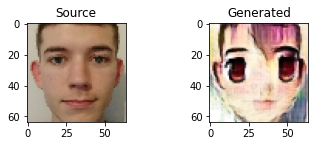

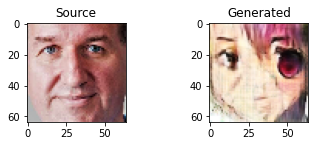

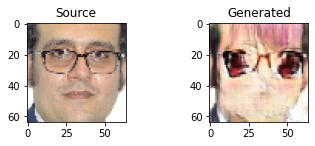

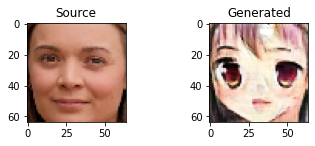

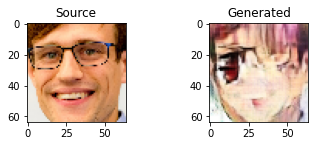

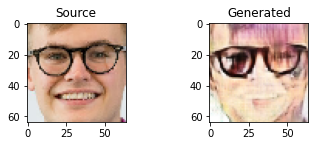

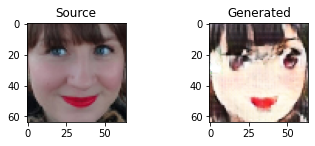

In [ ]:
#Generating anime faces from staff photos
generate_anime('./Test images', direction='AB')

**The converted anime images are then attempted to be converted back to human faces from anime. The images are recognisable as the original images but not perfect.**

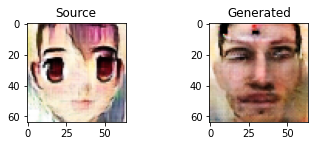

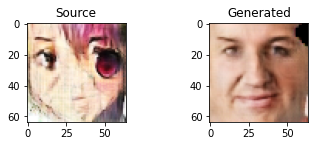

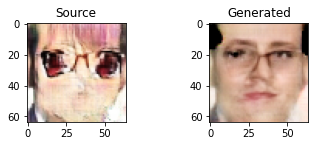

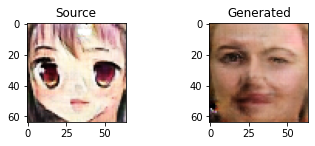

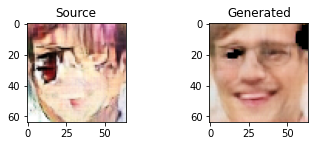

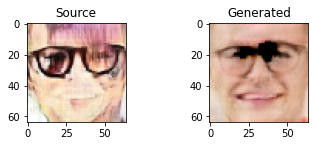

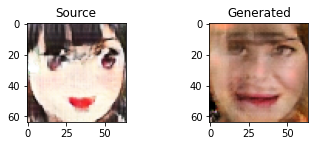

In [ ]:
# Attempting to translate back to human
generate_anime('./Test images', direction='BA')

**The `generate_human()` function can be used to convert any directory of anime images into human faces. The results are a little disturbing but you can see it has the right idea. I think these faces haven't quite reached the uncanny valley.**

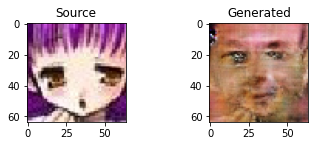

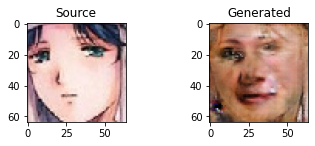

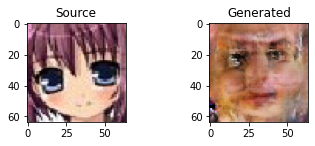

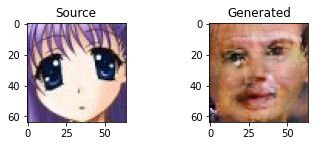

In [ ]:
generate_human('./anime_test_2/')

**The same direction='BA' argument can be passed to attempt to convert back to the original anime**

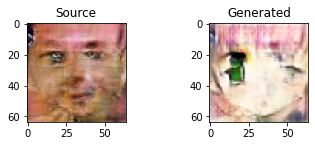

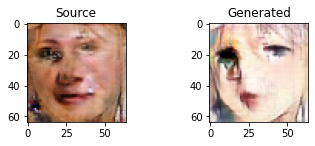

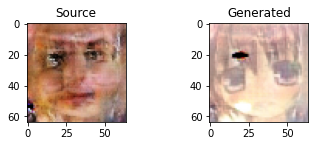

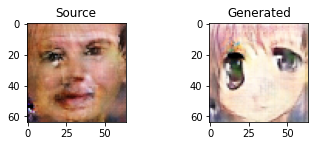

In [ ]:
generate_human('./anime_test_2/', direction='BA')

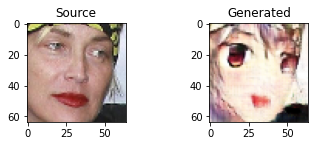

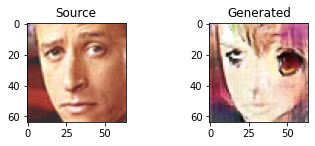

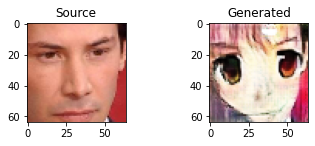

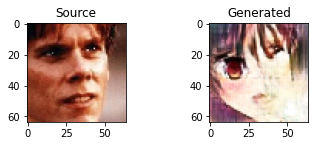

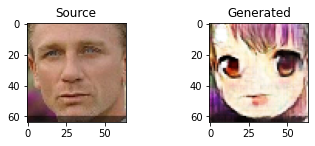

In [ ]:
# Processing sample of celeb images and generating fakes, plotting the results

#utilising function above to load in test images
filepath_test = './CelebDataProcessed/'
test_list = list()
for file in os.listdir(filepath_test):
  pic = os.fsdecode(file)
  pic = os.path.join(filepath_test, file)
  pic = load_image(pic)
  test_list.append(pic)

# translate image
celeb_transAB = list()
for i in range(5):
  celeb_transAB.append(g_model_AtoB.predict(test_list[i])) 
  # scale from [-1,1] to [0,1]
  celeb_transAB[i] = (celeb_transAB[i] + 1) / 2
  test_list[i] = (test_list[i] + 1) / 2

#plotting results
for i in range(5):
  fig = plt.figure()
  ax1 = fig.add_subplot(2,2,1)
  ax1.set_title('Source')
  ax1.imshow(test_list[i][0])
  ax2 = fig.add_subplot(2,2,2)
  ax2.set_title('Generated')
  ax2.imshow(celeb_transAB[i][0])

plt.show()

**Saving images from test**

In [ ]:
#Saving staff A -> B images
for i in range(7):
  plt.imsave("AB_" + str(i) + ".png", image_transAB[i][0])
#Saving staff B -> A images
for i in range(7):
  plt.imsave("BA_" + str(i) + ".png", image_transBA[i][0])

**References**

Amir Atapour-Abarghouei, 2021. *CSC8637: Deep Learning Lecture 11: Generative Models* Newcastle University School of Computing

Brownlee, J., 2021. *How to Develop a CycleGAN for Image-to-Image Translation with Keras.* [online] Machine Learning Mastery. Available at: <https://machinelearningmastery.com/cyclegan-tutorial-with-keras/> [Accessed 21 February 2021].

Gabriel della Maggiora, https://github.com/nanoxas/

Jun-Yan Zhu, Taesung Park, Phillip Isola, Alexei A. Efros, 2017. *Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks*, in IEEE International Conference on Computer Vision (ICCV), 2017.

Silva, T., 2021. Advanced GANs - Exploring Normalization Techniques for GAN training: Self-Attention and Spectral Norm - Thalles' blog. [online] Sthalles.github.io. Available at: <https://sthalles.github.io/advanced_gans/> [Accessed 21 February 2021].

Team, K., 2021. *Keras documentation: CycleGAN.* [online] Keras.io. Available at: <https://keras.io/examples/generative/cyclegan/> [Accessed 11 February 2021].
